In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vincenty import vincenty # geopy.distance can also be used

In [2]:
# import pour afficher les cartes
from plotly.offline import iplot, init_notebook_mode
import colorlover as cl
import plotly.express as px
import plotly.graph_objects as go

# init
init_notebook_mode(connected=True)

In [3]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

In [4]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [4]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [5]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [6]:
df_mess_train['lat'] = pos_train['lat']
df_mess_train['lng'] = pos_train['lng']

In [7]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]) for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [8]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [9]:
# on rajoute distance device-station dans df_mess_train
df_mess_train['d_base'] = Eval_geoloc(df_mess_train['bs_lat'],df_mess_train['bs_lng'],pos_train['lat'],pos_train['lng'])

In [10]:
# filtrage final des anomalies du train
df_mess_train_filter3 = df_mess_train[(df_mess_train['messid']!= '57aeb41fe541cd77a044cdb8')
                      & (df_mess_train['d_base'] <= 50)]
df_mess_train_filter3.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,d_base
count,34579.000000,3.457900e+04,34579.000000,34579.000000,3.457900e+04,34579.000000,34579.000000,34579.000000,34579.000000,34579.000000
mean,4335.964979,4.817589e+05,1.044651,-125.899192,1.473000e+12,39.798268,-105.064546,39.786442,-105.059899,5.572419
std,2364.338923,8.630330e+04,0.558705,9.217687,5.577516e+09,0.216214,0.177424,0.216460,0.171193,5.309702
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146,35.770683,-107.630679,0.026570
25%,2790.000000,4.761850e+05,1.000000,-132.500000,1.467906e+12,39.744848,-105.077530,39.708524,-105.063613,2.013047
50%,3554.000000,4.763150e+05,1.000000,-127.500000,1.472830e+12,39.781464,-105.050984,39.777623,-105.042091,3.983613
75%,4790.000000,4.766020e+05,1.500000,-121.000000,1.478673e+12,39.816224,-105.010048,39.807485,-105.018761,7.496166
max,10148.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,42.850670,-102.011461,43.140387,-102.094289,47.237609


In [11]:
pos_train_filter3 = pos_train.reindex(df_mess_train_filter3.index)

In [12]:
listOfDev = df_mess_train['did'].unique()
len(listOfDev)

113

In [13]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [14]:
len(listOfBs)

259

In [15]:
# Feature Matrix construction avec 0/1 activation balises

def feat_mat_const(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
#         df_mess_bs_group.get_group(key)
#         df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = 1
        df_feat.loc[idx,elmt['bsid']] = 1
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

In [110]:
# Feature Matrix construction avec rssi balises

def feat_mat_const2(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs)))-2000, columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
#         group = df_mess_bs_group.get_group(key)
#         df_feat.loc[idx,group['bsid']] = group['rssi'].values
        df_feat.loc[idx,elmt['bsid']] = elmt['rssi'].values
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

In [17]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [22]:
# on regroupe les infos par message feat 0/1
df_feat_filter, id_list_train_filter = feat_mat_const(df_mess_train_filter3, listOfBs)
df_feat_filter.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9936,9941,9949,10134,10148,10151,10162,10999,11007,11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_feat_filter.shape

(5868, 259)

In [111]:
# on regroupe les infos par message feat rssi
df_feat2_filter, id_list_train2_filter = feat_mat_const2(df_mess_train_filter3, listOfBs)
df_feat2_filter.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9936,9941,9949,10134,10148,10151,10162,10999,11007,11951
0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,...,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0
1,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,...,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0
2,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,...,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0
3,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,...,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0
4,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-141.0,-2000.0,-2000.0,-2000.0,...,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0


In [24]:
ground_truth_lat_filter, ground_truth_lng_filter = ground_truth_const(df_mess_train_filter3, pos_train_filter3)
ground_truth_lat_filter.shape

(5868,)

In [25]:
# liste des devices dce chaque message, à utiliser pour la stratégie Leave one device Out
dev_id = df_mess_train_filter3.groupby(['messid'])['did'].first()
dev_id.shape

(5868,)

In [63]:
# Validation

In [64]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng

    from sklearn import linear_model

    X_train = np.array(df_feat);
    reg = linear_model.LinearRegression()

    reg.fit(X_train, ground_truth_lat);
    y_pred_lat = reg.predict(df_test) 

    reg.fit(X_train, ground_truth_lng);
    y_pred_lng = reg.predict(df_test) 
    
    return y_pred_lat, y_pred_lng


In [65]:
# Make regressor and prediction using the train set

In [66]:
# Cross validation

In [116]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, LeaveOneGroupOut, GroupKFold

In [99]:
logo = LeaveOneGroupOut()

In [104]:
logo.get_n_splits(df_feat_filter,groups=dev_id)

113

In [137]:
group_kfold = GroupKFold(n_splits=10)

In [138]:
group_kfold.get_n_splits(df_feat_filter,groups=dev_id)

10

### LinearRegression

In [56]:
from sklearn import linear_model

In [57]:
# with feat 0/1 & leave one group out

12.470912400000014


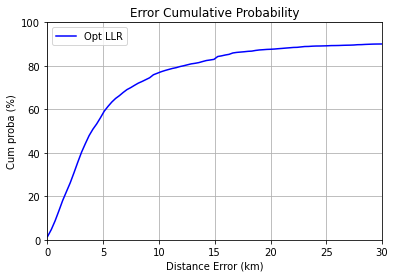

In [91]:
reg = linear_model.LinearRegression()

# Cross validation
y_pred_lng = cross_val_predict(reg, df_feat_filter, ground_truth_lng_filter,cv=logo.split(df_feat_filter,groups=dev_id))
y_pred_lat = cross_val_predict(reg, df_feat_filter, ground_truth_lat_filter,cv=logo.split(df_feat_filter,groups=dev_id))

err_vec = Eval_geoloc(ground_truth_lat_filter , ground_truth_lng_filter, y_pred_lat, y_pred_lng)

# Plot error distribution

values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values)
plt.figure()
plt.plot(base[:-1], cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid()
plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100])
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

# Error criterion
print(np.percentile(err_vec, 80))

In [233]:
# with rssi features LOGO

12.435958400000017


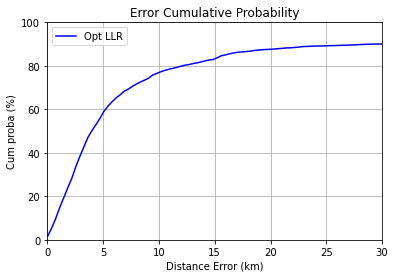

In [112]:
reg = linear_model.LinearRegression()

# Cross validation
y_pred_lng = cross_val_predict(reg, df_feat2_filter, ground_truth_lng_filter, cv=logo.split(df_feat2_filter,groups=dev_id))
y_pred_lat = cross_val_predict(reg, df_feat2_filter, ground_truth_lat_filter, cv=logo.split(df_feat2_filter,groups=dev_id))

err_vec = Eval_geoloc(ground_truth_lat_filter , ground_truth_lng_filter, y_pred_lat, y_pred_lng)

# Plot error distribution

values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values)
plt.figure()
plt.plot(base[:-1], cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid()
plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100])
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

# Error criterion
print(np.percentile(err_vec, 80))

### RandomForestRegressor

In [96]:
from sklearn.ensemble import RandomForestRegressor

In [97]:
# with 0/1 feat LOGO Très Très Long !

5.895037600000002


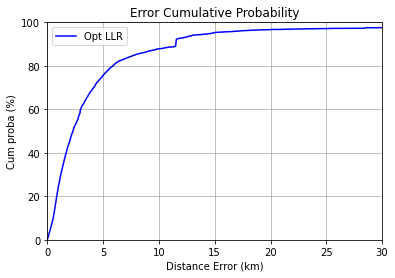

In [103]:
reg = RandomForestRegressor()

# Cross validation
y_pred_lng = cross_val_predict(reg, df_feat_filter, ground_truth_lng_filter, cv=logo.split(df_feat_filter,groups=dev_id))
y_pred_lat = cross_val_predict(reg, df_feat_filter, ground_truth_lat_filter, cv=logo.split(df_feat_filter,groups=dev_id))

err_vec = Eval_geoloc(ground_truth_lat_filter , ground_truth_lng_filter, y_pred_lat, y_pred_lng)

# Plot error distribution

values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values)
plt.figure()
plt.plot(base[:-1], cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid()
plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100])
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

# Error criterion
print(np.percentile(err_vec, 80))

In [97]:
# with 0/1 feat group_kfold 10 OK

5.988313800000004


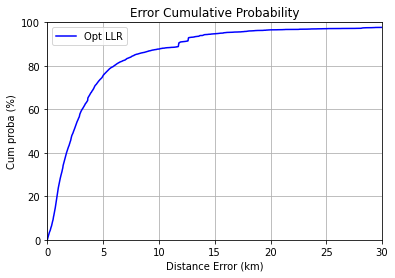

In [139]:
reg = RandomForestRegressor()

# Cross validation
y_pred_lng = cross_val_predict(reg, df_feat_filter, ground_truth_lng_filter, cv=group_kfold.split(df_feat2_filter,groups=dev_id))
y_pred_lat = cross_val_predict(reg, df_feat_filter, ground_truth_lat_filter, cv=group_kfold.split(df_feat2_filter,groups=dev_id))

err_vec = Eval_geoloc(ground_truth_lat_filter , ground_truth_lng_filter, y_pred_lat, y_pred_lng)

# Plot error distribution

values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values)
plt.figure()
plt.plot(base[:-1], cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid()
plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100])
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

# Error criterion
print(np.percentile(err_vec, 80))

In [140]:
# with rssi group_kfold 10 OK

6.612360799999999


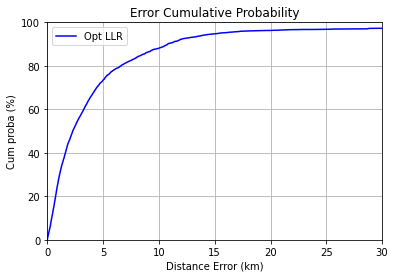

In [141]:
reg = RandomForestRegressor()

# Cross validation
y_pred_lng = cross_val_predict(reg, df_feat2_filter, ground_truth_lng_filter,
                               cv=group_kfold.split(df_feat2_filter,groups=dev_id))
y_pred_lat = cross_val_predict(reg, df_feat2_filter, ground_truth_lat_filter,
                               cv=group_kfold.split(df_feat2_filter,groups=dev_id))

err_vec = Eval_geoloc(ground_truth_lat_filter , ground_truth_lng_filter, y_pred_lat, y_pred_lng)

# Plot error distribution

values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values)
plt.figure()
plt.plot(base[:-1], cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid()
plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100])
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

# Error criterion
print(np.percentile(err_vec, 80))

In [25]:
# Construct test prediction

In [44]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [78]:
df_feat, id_list_train = feat_mat_const(df_mess_train, listOfBs)

In [83]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

(6068,)

In [84]:
df_feat_test, id_list_test = feat_mat_const(df_mess_test, listOfBs)

In [85]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)

In [86]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = id_list_test

In [87]:
test_res.to_csv('pred_pos_test_list.csv', index=False)

In [88]:
test_res.head()

,lat,lng,messid
0,39.772912,-105.049629,573be2503e952e191262c351
1,39.774800,-105.062448,573c05f83e952e1912758013
2,39.678750,-105.012794,573c0796f0fe6e735a66deb3
3,39.773684,-105.037449,573c08d2864fce1a9a0563bc
4,39.678750,-105.012794,573c08ff864fce1a9a0579b0
